## Meridional Overturning Circulation

In [1]:
%%capture 
# comment above line to see details about the run(s) displayed
# from misc import *
%matplotlib inline

In [ ]:
### Temporarily just pasting in all of misc

import xarray as xr
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import warnings, os, yaml
import matplotlib
import getpass
import netCDF4
# mom6_tools
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import xyplot, ztplot
from mom6_tools.poleward_heat_transport import heatTrans, plotHeatTrans, plotGandW

import pop_tools

matplotlib.rcParams.update({'font.size': 18})
warnings.filterwarnings("ignore")

diag_config_yml = yaml.load(open('/glade/u/home/eromashkova/codes/nbscuid-examples/mom6-solutions/nblibrary/diag_config.yml','r'),
                            Loader=yaml.Loader)
# initialize lists
dcase = []; casename=[]
label = []; OUTDIR=[]
ocn_path = []
ncases = len(diag_config_yml.keys()) - 1
if ncases < 2:
  # Create the case instance
  dcase = DiagsCase(diag_config_yml['Case'], xrformat=True)
  casename.append(dcase.casename)
  label.append(diag_config_yml['Case']['SNAME'])
  ocn_path.append(diag_config_yml['Case']['OCN_DIAG_ROOT'])
  DOUT_S = dcase.get_value('DOUT_S')
  if DOUT_S:
    OUTDIR.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
  else:
    OUTDIR.append(dcase.get_value('RUNDIR')+'/')
else:
  for i in range(ncases):
    cname = 'Case{}'.format(i+1)
    dcase = DiagsCase(diag_config_yml[cname], xrformat=True)
    casename.append(dcase.casename)
    label.append(diag_config_yml[cname]['SNAME'])
    ocn_path.append(diag_config_yml[cname]['OCN_DIAG_ROOT'])
    DOUT_S = dcase.get_value('DOUT_S')
    if DOUT_S:
      OUTDIR.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
    else:
      OUTDIR.append(dcase.get_value('RUNDIR')+'/')

# set avg dates
avg = diag_config_yml['Avg']
start_date = avg['start_date']
end_date = avg['end_date']

print('Casename is {}'.format(casename))
print('─' * 60)
print('Averaged between {} and {}'.format(start_date, end_date))
print('─' * 60)
print('Output directory is:', OUTDIR)
print('─' * 60)
print('Generated by {}'.format(getpass.getuser()))
print('─' * 60)
print("Last update:", date.today())

# load grid and pre-difined masks
grd = MOM6grid(OUTDIR[0]+casename[0]+'.mom6.static.nc');
grd_xr = MOM6grid(OUTDIR[0]+casename[0]+'.mom6.static.nc', xrformat=True);
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True);

# pop grid
pop_grid = pop_tools.get_grid('POP_gx1v7')

def get_heat_transport_obs():
    """Plots model vs obs poleward heat transport for the global, Pacific and Atlantic basins"""
    # Load Observations
    fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
    #Trenberth and Caron
    yobs = fObs.variables['ylat'][:]
    NCEP = {}; NCEP['Global'] = fObs.variables['OTn']
    NCEP['Atlantic'] = fObs.variables['ATLn'][:]; NCEP['IndoPac'] = fObs.variables['INDPACn'][:]
    ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
    ECMWF['Atlantic'] = fObs.variables['ATLe'][:]; ECMWF['IndoPac'] = fObs.variables['INDPACe'][:]

    #G and W
    Global = {}
    Global['lat'] = np.array([-30., -19., 24., 47.])
    Global['trans'] = np.array([-0.6, -0.8, 1.8, 0.6])
    Global['err'] = np.array([0.3, 0.6, 0.3, 0.1])

    Atlantic = {}
    Atlantic['lat'] = np.array([-45., -30., -19., -11., -4.5, 7.5, 24., 47.])
    Atlantic['trans'] = np.array([0.66, 0.35, 0.77, 0.9, 1., 1.26, 1.27, 0.6])
    Atlantic['err'] = np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09])

    IndoPac = {}
    IndoPac['lat'] = np.array([-30., -18., 24., 47.])
    IndoPac['trans'] = np.array([-0.9, -1.6, 0.52, 0.])
    IndoPac['err'] = np.array([0.3, 0.6, 0.2, 0.05,])

    GandW = {}
    GandW['Global'] = Global
    GandW['Atlantic'] = Atlantic
    GandW['IndoPac'] = IndoPac
    return NCEP, ECMWF, GandW, yobs

NCEP, ECMWF, GandW, yobs = get_heat_transport_obs()

def get_adv_diff(ds):
    # create a ndarray subclass
    class C(np.ndarray): pass

    varName = 'T_ady_2d'
    if varName in ds.variables:
        tmp = np.ma.masked_invalid(ds[varName].values)
        tmp = tmp[:].filled(0.)
        advective = tmp.view(C)
        advective.units = 'W'
    else:
        raise Exception('Could not find "T_ady_2d"')

    varName = 'T_diffy_2d'
    if varName in ds.variables:
        tmp = np.ma.masked_invalid(ds[varName].values)
        tmp = tmp[:].filled(0.)
        diffusive = tmp.view(C)
        diffusive.units = 'W'
    else:
        diffusive = None
        warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

    varName = 'T_lbd_diffy_2d'
    if varName in ds.variables:
        tmp = np.ma.masked_invalid(ds[varName].values)
        tmp = tmp[:].filled(0.)
        diffusive = diffusive + tmp.view(C)
    else:
        warnings.warn('Horizontal boundary mixing term not found. This will result in an underestimation of the heat transport.')

    return advective, diffusive

def plot_heat_trans(ds, label, linestyle='-'):
    adv, diff = get_adv_diff(ds)
    HT = heatTrans(adv,diff); y = ds.yq
    plt.plot(y, HT, linewidth=3, linestyle=linestyle, label=label)
    return

def heatTrans(advective, diffusive=None, hbd=None, vmask=None, units="W"):
  """Converts vertically integrated temperature advection/diffusion into heat transport"""
  HT = advective[:]
  if diffusive is not None:
    HT = HT + diffusive[:]
  if hbd is not None:
    HT = HT + hbd[:]
  if len(HT.shape) == 3:
    HT = HT.mean(axis=0)
  if units == "Celsius meter3 second-1":
    rho0 = 1.035e3
    Cp = 3992.
    HT = HT * (rho0 * Cp)
    HT = HT * 1.e-15  # convert to PW
  elif units == "W":
    HT = HT * 1.e-15
  else:
    print('Unknown units')
  if vmask is not None: HT = HT*vmask
  HT = HT.sum(axis=-1); HT = HT.squeeze() # sum in x-direction
  return HT

def pop_add_cyclic(ds):

    nj = ds.TLAT.shape[0]
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data

    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]

    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.
    lon = lon - 360.

    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8

    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))

    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})

    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'),
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})


    return dso

pop_grid_o = pop_add_cyclic(pop_grid)





In [7]:
# empty parametrizable cell 

cluster_scheduler_address = None

## Connecting to cluster

In [8]:
from dask.distributed import Client

if cluster_scheduler_address is None:
    cluster, client = nbscuid.util.get_ClusterClient()
    cluster.scale(12)
else:
    client = Client(cluster_scheduler_address)
client

NameError: name 'cluster_scheduler_address' is not defined

In [2]:
ds = []
for c, l, p in zip(casename,label, ocn_path):
  dummy = xr.open_dataset(p+'{}_MOC.nc'.format(c))
  ds.append(dummy) 

### Global MOC

In [3]:
# Global MOC
from  mom6_tools import m6plot, m6toolbox
from mom6_tools.moc import  *
import glob

# this hack needs to be fixed
file = sorted(glob.glob(OUTDIR[0]+'/*.h_*.nc'))[0:2]

ds1 = xr.open_mfdataset(file)

varName = 'vmo'
Zmod = m6toolbox.get_z(ds1, depth, varName)

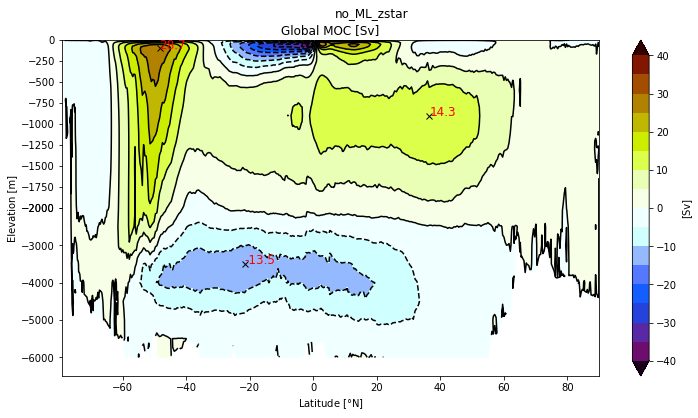

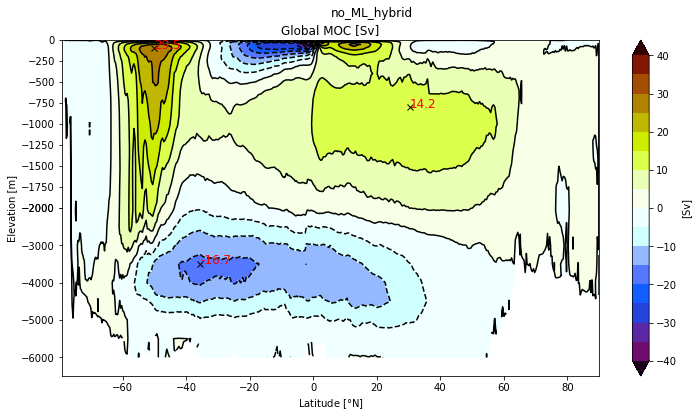

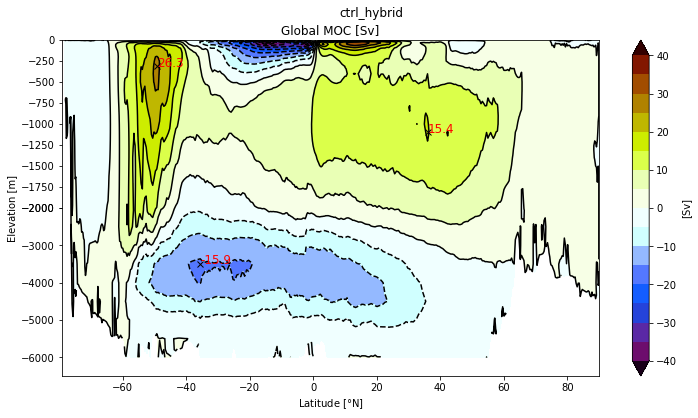

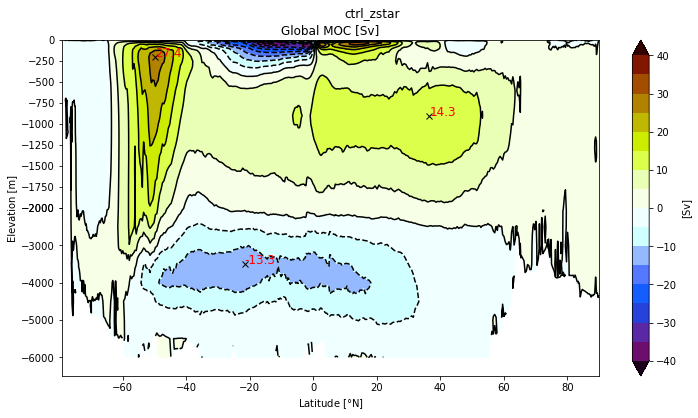

In [4]:
pnum = len(ds)
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  axis = plt.gca()
  cmap = plt.get_cmap('dunnePM')
  zg = Zmod.min(axis=-1); 
  psiPlot = ds[i].moc.values
  yyg = grd.geolat_c[:,:].max(axis=-1)+0*zg

  ci=m6plot.pmCI(0.,40.,5.)
  plotPsi(yyg, zg, psiPlot, ci, 'Global MOC [Sv]')
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(label[i])

  findExtrema(yyg, zg, psiPlot, max_lat=-30.)
  findExtrema(yyg, zg, psiPlot, min_lat=25., min_depth=250.)
  findExtrema(yyg, zg, psiPlot, min_depth=2000., mult=-1.)
  plt.gca().invert_yaxis()


### Atlantic MOC

In [5]:
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=False);

11.16428 64.78855 [391, 434]


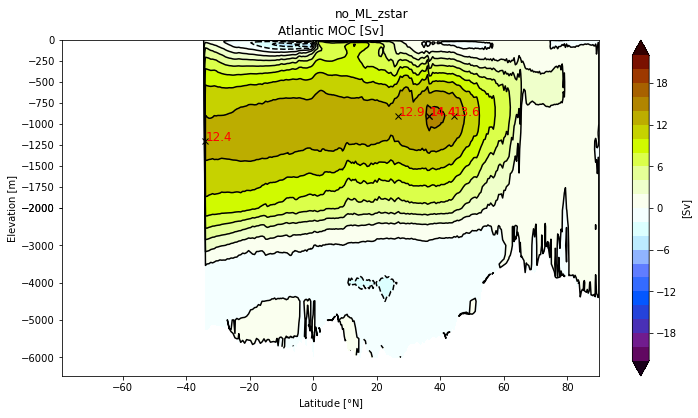

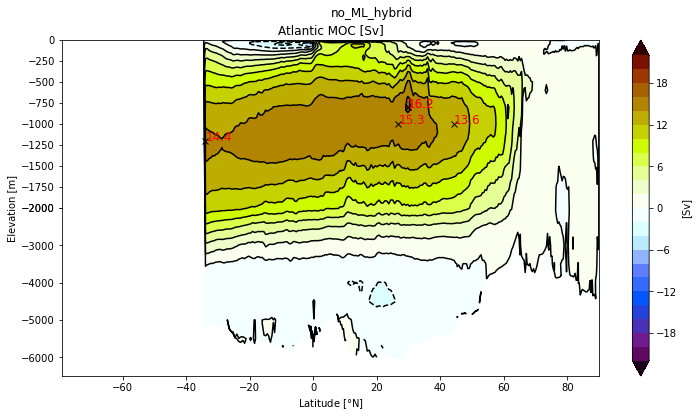

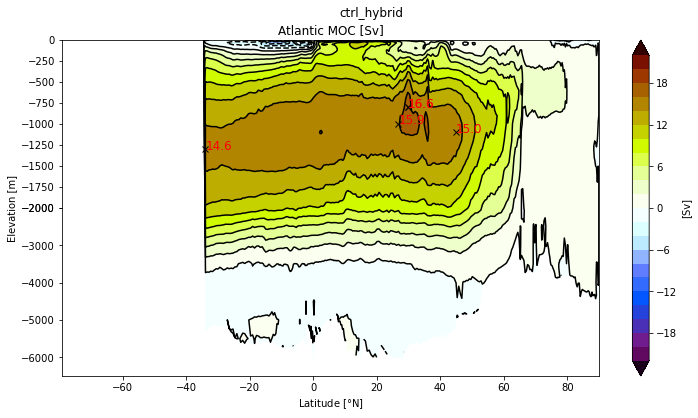

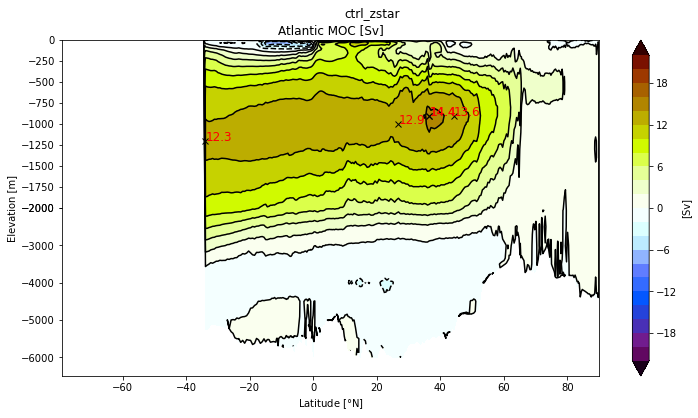

In [6]:
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  cmap = plt.get_cmap('dunnePM')
  ci=m6plot.pmCI(0.,22.,2.)
  m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)]=1
  z = (m*Zmod).min(axis=-1)
  psiPlot = ds[i].amoc.values
  yy = grd.geolat_c[:,:].max(axis=-1)+0*z
  plotPsi(yy, z, psiPlot, ci, 'Atlantic MOC [Sv]')
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(label[i])
  findExtrema(yy, z, psiPlot, min_lat=26.5, max_lat=27., min_depth=250.) # RAPID
  findExtrema(yy, z, psiPlot, min_lat=44, max_lat=46., min_depth=250.) # RAPID
  findExtrema(yy, z, psiPlot, max_lat=-33.)
  findExtrema(yy, z, psiPlot)
  findExtrema(yy, z, psiPlot, min_lat=5.)
  plt.gca().invert_yaxis()

### AMOC profile at 26N

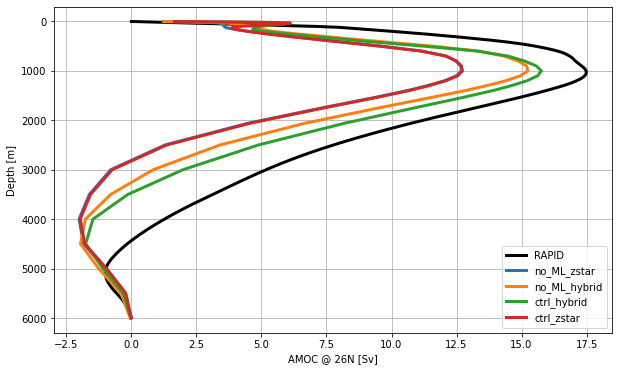

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
rapid_vertical = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_vertical.nc')
ax.plot(rapid_vertical.stream_function_mar.mean('time'),
        rapid_vertical.depth, 'k', label='RAPID', lw=3)
for i in range(pnum):
  ax.plot(ds[i]['amoc'].sel(yq=26, method='nearest'), ds[i].zl, label=label[i], lw=3)

ax.legend()
plt.gca().invert_yaxis()
plt.grid()
ax.set_xlabel('AMOC @ 26N [Sv]')
ax.set_ylabel('Depth [m]');

### AMOC time series

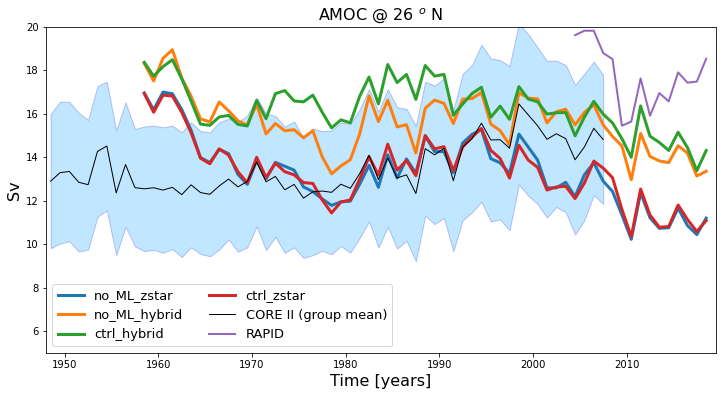

In [8]:
# load AMOC time series data (5th) cycle used in Danabasoglu et al., doi:10.1016/j.ocemod.2015.11.007
path = '/glade/p/cesm/omwg/amoc/COREII_AMOC_papers/papers/COREII.variability/data.original/'
amoc_core_26 = xr.open_dataset(path+'AMOCts.cyc5.26p5.nc')
# load AMOC from POP JRA-55
#amoc_pop_26 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
#                              'AMOC_series_26n.g210.GIAF_JRA.v13.gx1v7.01.nc') 
# load RAPID time series
rapid = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_transports.nc').resample(time="1Y", 
                            closed='left',keep_attrs=True).mean('time',keep_attrs=True)

# plot
fig = plt.figure(figsize=(12, 6))
for i in range(pnum):
  plt.plot(np.arange(len(ds[i].time))+1958.5 ,ds[i]['amoc_26'].values, 
           label=label[i], lw=3)
# core data
core_mean = amoc_core_26['MOC'].mean(axis=0).data
core_std = amoc_core_26['MOC'].std(axis=0).data
plt.plot(amoc_core_26.time,core_mean, label='CORE II (group mean)', 
         color='black', lw=1)
plt.fill_between(amoc_core_26.time, core_mean-core_std, core_mean+core_std,
  alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')
# pop data
#plt.plot(np.arange(len(amoc_pop_26.time))+1958.5 ,amoc_pop_26.AMOC_26n.values, 
#         label='POP', lw=2)
# rapid
plt.plot(np.arange(len(rapid.time))+2004.5 ,rapid.moc_mar_hc10.values, 
         label='RAPID', lw=2)

plt.title('AMOC @ 26 $^o$ N', fontsize=16)
plt.ylim(5,20)
plt.xlim(1948,1958.5+len(ds[0].time))
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=13, ncol=2);

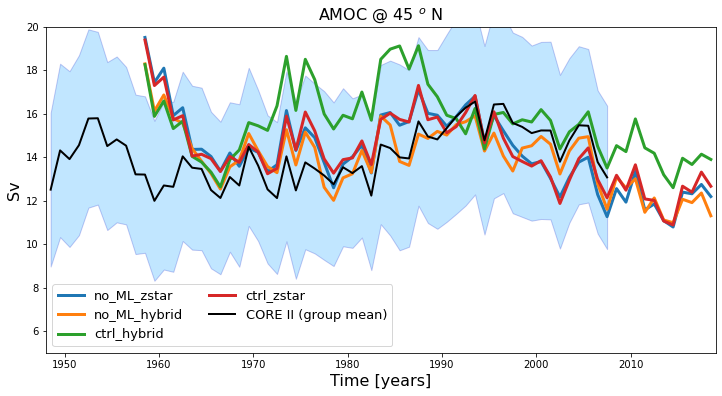

In [9]:
amoc_core_45 = xr.open_dataset(path+'AMOCts.cyc5.45.nc')
#amoc_pop_45 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
#                              'AMOC_series_45n.g210.GIAF_JRA.v13.gx1v7.01.nc')

# plot
fig = plt.figure(figsize=(12, 6))
for i in range(pnum):
  plt.plot(np.arange(len(ds[i].time))+1958.5 ,ds[i]['amoc_45'].values, 
           label=label[i], lw=3)
# core data
core_mean = amoc_core_45['MOC'].mean(axis=0).data
core_std = amoc_core_45['MOC'].std(axis=0).data
plt.plot(amoc_core_45.time,core_mean, label='CORE II (group mean)', 
         color='black', lw=2)
plt.fill_between(amoc_core_45.time, core_mean-core_std, core_mean+core_std,
  alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')
# pop data
#plt.plot(np.arange(len(amoc_pop_45.time))+1958. ,
#         amoc_pop_45.AMOC_45n.values, label='POP', lw=2)

plt.title('AMOC @ 45 $^o$ N', fontsize=16)
plt.ylim(5,20)
plt.xlim(1948,1958+len(ds[0].time))
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=13, ncol=2);

### Submesoscale-induced Global MOC

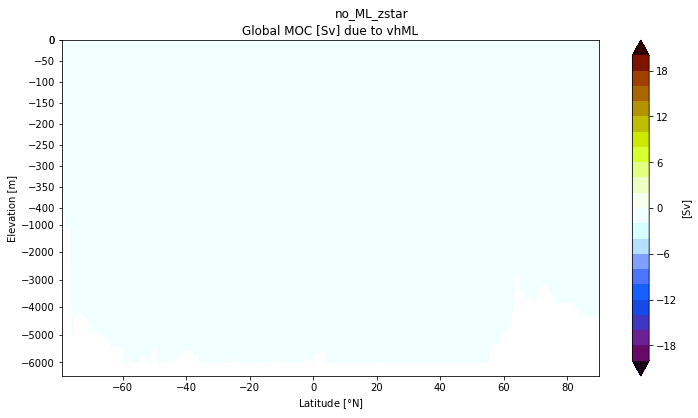

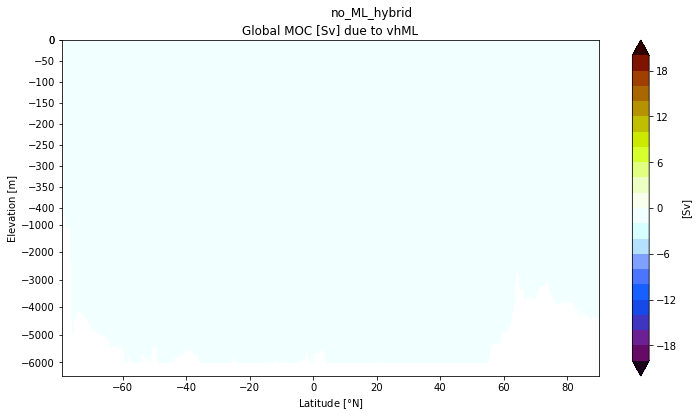

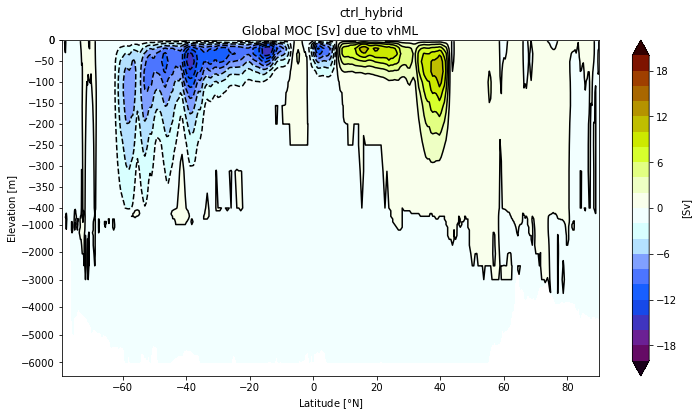

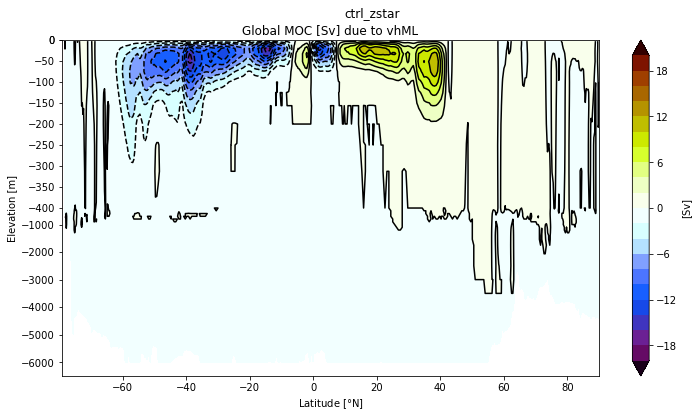

In [10]:
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  axis = plt.gca()
  cmap = plt.get_cmap('dunnePM')
  z = Zmod.min(axis=-1); 
  psiPlot = ds[i].moc_FFM.values
  #yy = y[1:,:].max(axis=-1)+0*z
  yy = grd.geolat_c[:,:].max(axis=-1)+0*z
  ci=m6plot.pmCI(0.,20.,2.)
  plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv] due to vhML', zval=[0.,-400.,-6500.])
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(label[i])
  plt.gca().invert_yaxis()

#### Eddy(GM)-induced Global MOC

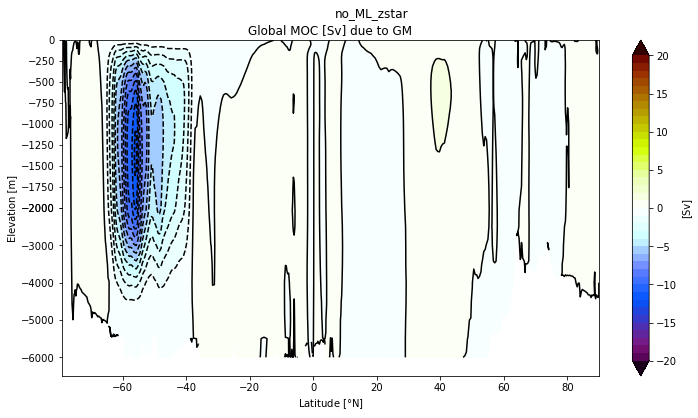

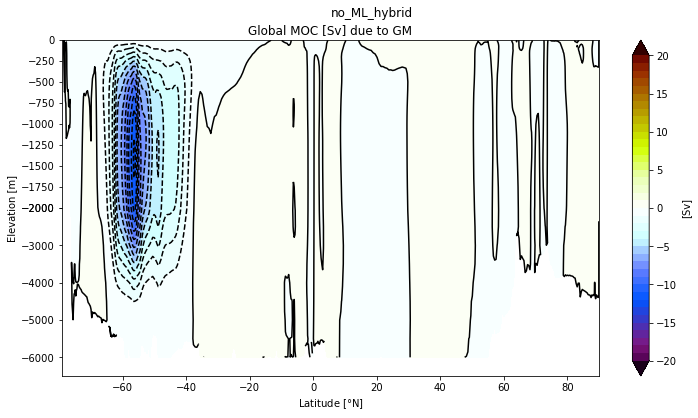

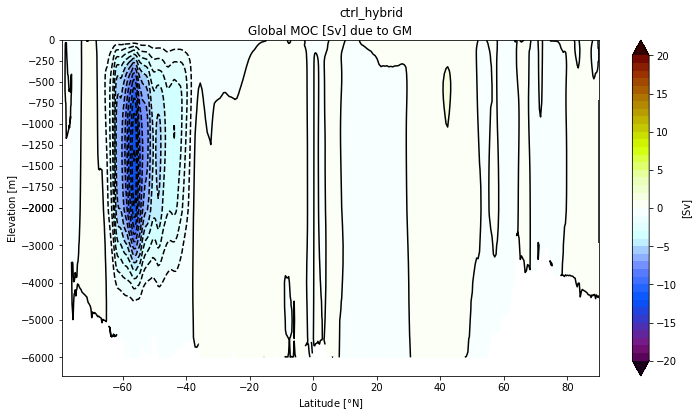

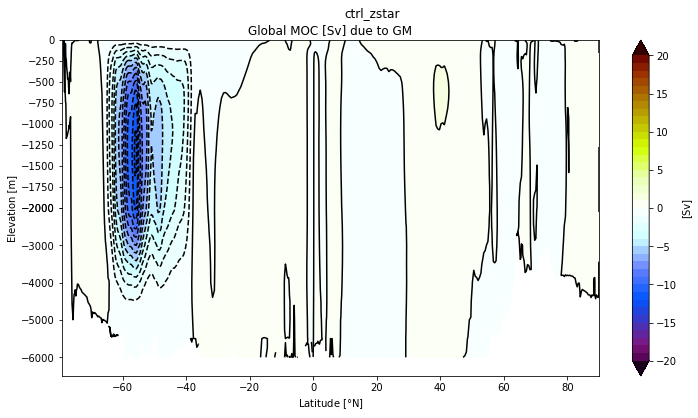

In [11]:
for i in range(pnum):
  m6plot.setFigureSize([16,9],576,debug=False)
  axis = plt.gca()
  cmap = plt.get_cmap('dunnePM')
  z = Zmod.min(axis=-1); 
  psiPlot = ds[i].moc_GM
  yy = grd.geolat_c[:,:].max(axis=-1)+0*z
  ci=m6plot.pmCI(0.,20.,1.)
  plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv] due to GM')
  plt.xlabel(r'Latitude [$\degree$N]')
  plt.suptitle(label[i])
  plt.gca().invert_yaxis()